Epoch 1/20
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 70s 36ms/step - loss: 0.1342 - val_loss: 0.0742
Epoch 2/20
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 52s 30ms/step - loss: 0.0733 - val_loss: 0.0707
Epoch 3/20
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 53s 30ms/step - loss: 0.0705 - val_loss: 0.0693
Epoch 4/20
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 53s 30ms/step - loss: 0.0692 - val_loss: 0.0683
Epoch 5/20
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 52s 29ms/step - loss: 0.0683 - val_loss: 0.0675
Epoch 6/20
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 37s 21ms/step - loss: 0.0676 - val_loss: 0.0671
Epoch 7/20
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 34s 19ms/step - loss: 0.0673 - val_loss: 0.0668
Epoch 8/20
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 34s 20ms/step - loss: 0.0670 - val_loss: 0.0665
Epoch 9/20
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 34s 19ms/step - loss: 0.0668 - val_loss: 0.0663
Epoch 10/20
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 35s 20ms/step - loss: 0.0664 - val_loss: 0.0659
Epoch 11/20
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 36s 21ms/step - loss: 0.0662 - val_loss: 0.0658
Epoch 12

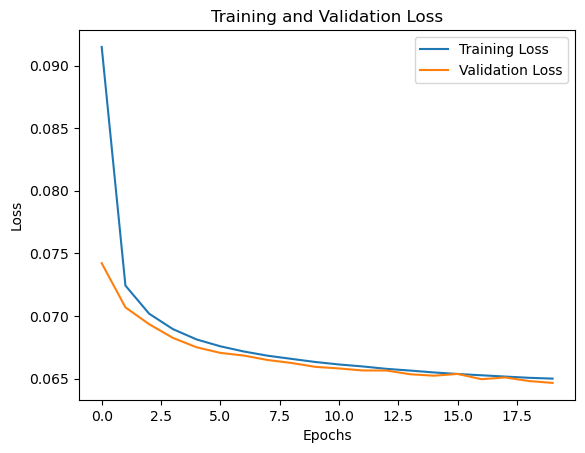

438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step


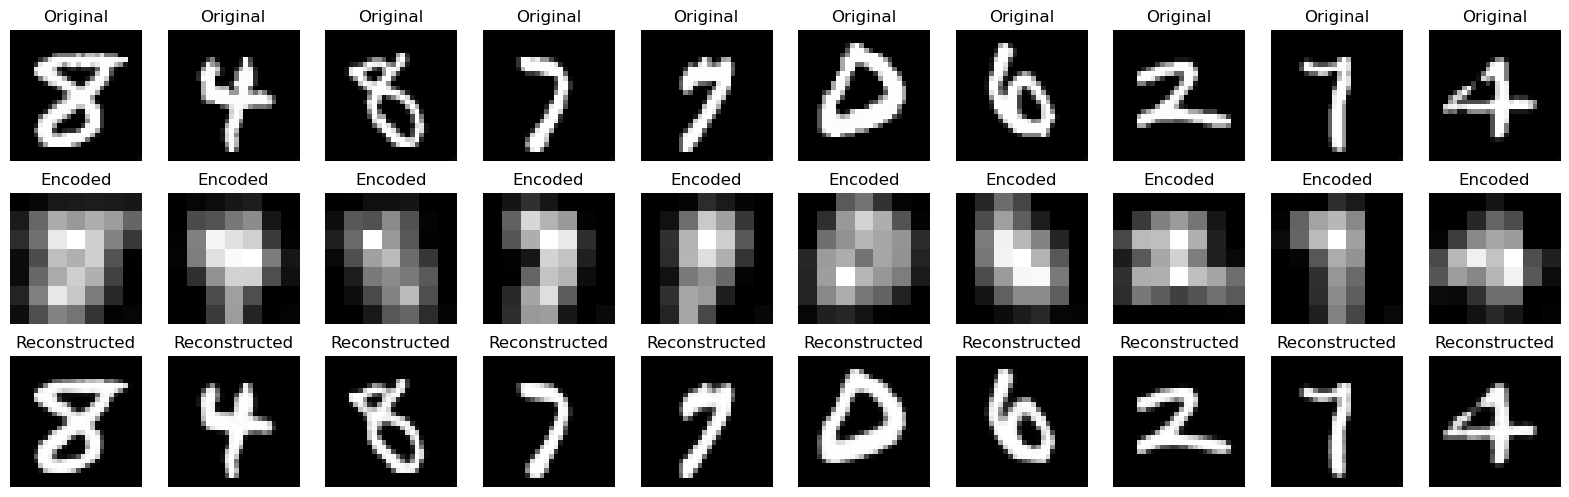

In [4]:
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical

# Load data from CSV
data = pd.read_csv('mnist_784_csv.csv')

# Separate features and labels
X = data.iloc[:, 1:].values  # All columns except the first one (pixel values)
y = data.iloc[:, 0].values   # First column (labels)

# Split into training and test sets (e.g., 80% train, 20% test)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize pixel values
x_train = x_train / 255.0
x_test = x_test / 255.0

# Reshape to 28x28 images (optional)
x_train = x_train.reshape(-1, 28, 28)
x_test = x_test.reshape(-1, 28, 28)

# Convert labels to categorical one-hot encoding
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

def build_autoencoder():
    input_img = Input(shape=(28, 28, 1))
    
    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same', activity_regularizer=regularizers.l1(1e-5))(x)
    
    # Decoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    
    autoencoder = Model(input_img, decoded)
    return autoencoder

# Build, compile, and train the autoencoder
autoencoder = build_autoencoder()
autoencoder.compile(optimizer=Adam(), loss='binary_crossentropy')

history = autoencoder.fit(
    x_train, x_train,
    epochs=20,
    batch_size=32,
    shuffle=True,
    validation_data=(x_test, x_test)
)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Encoder to reduce dimensionality
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.layers[4].output)

# Generate encoded and decoded images
encoded_imgs = encoder.predict(x_test)
decoded_imgs = autoencoder.predict(x_test)

def plot_comparison_with_encoded(n=10):
    plt.figure(figsize=(20, 6))
    for i in range(n):
        # Display original image
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
        plt.title("Original")
        plt.axis('off')

        # Display encoded image (latent space)
        ax = plt.subplot(3, n, i + 1 + n)
        encoded_image = encoded_imgs[i]
        if len(encoded_image.shape) == 3:
            encoded_image = np.mean(encoded_image, axis=-1)
        plt.imshow(encoded_image, cmap='gray')
        plt.title("Encoded")
        plt.axis('off')

        # Display reconstructed image
        ax = plt.subplot(3, n, i + 1 + 2*n)
        plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
        plt.title("Reconstructed")
        plt.axis('off')
    plt.show()

# Plot original, encoded, and reconstructed images
plot_comparison_with_encoded(n=10)
